In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="2";  
 
# Do other imports now...
import tensorflow as tf

In [2]:
from utils_092019_tf2 import *

In [3]:
# import libraries
import pandas as pd
import numpy as np
import dask.dataframe as dd
from dask.distributed import Client
import seaborn as sns
import pickle

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import normalize
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

datafolder = '/data/clin_notes_outcomes/prissmm_notes/'

In [4]:
# read dataset into Pandas (pd)
labeled_notes = pd.read_feather(datafolder+ 'ap_analysis.feather')
print(labeled_notes.info())
labeled_notes = labeled_notes[labeled_notes.ap != '']
print(labeled_notes.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7597 entries, 0 to 7596
Data columns (total 11 columns):
dfci_mrn         7597 non-null int64
date             7597 non-null datetime64[ns]
text             7597 non-null object
source           7597 non-null object
department       7311 non-null object
provider_name    7597 non-null object
report_type      7597 non-null object
any_cancer       7597 non-null int64
response         7597 non-null int64
progression      7597 non-null int64
ap               7597 non-null object
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 653.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7597 entries, 0 to 7596
Data columns (total 11 columns):
dfci_mrn         7597 non-null int64
date             7597 non-null datetime64[ns]
text             7597 non-null object
source           7597 non-null object
department       7311 non-null object
provider_name    7597 non-null object
report_type      7597 non-null object
any_cancer     

In [ ]:
# pull in information on patient vital status, demographics, tumor specimens
datafolder = '/data/clin_notes_outcomes/clin_trajectory_v3/'
registration = pd.read_csv(datafolder + 'REQ_82268_PT_INFO_STATUS_REGISTRATION.csv', sep='|', encoding='ISO-8859-1', low_memory=False)

demographics = pd.read_csv(datafolder + 'REQ_82268_DEMOGRAPHICS_REGISTRATION.csv', sep='|', encoding='ISO-8859-1', low_memory=False)[['patient_id','marital_status_nm','idm_race_nm']]
specimens = pd.read_csv(datafolder + 'REQ_82268_GENOMIC_SPECIMEN.csv', sep='|', encoding='ISO-8859-1', low_memory=False)[['patient_id', 'test_order_dt', 'primary_cancer_diagnosis']]
specimens.test_order_dt = pd.to_datetime(specimens.test_order_dt)

specimens.head()

In [6]:
registration = registration[~registration.dfci_mrn.isnull()]
registration = registration[~registration.patient_id.isnull()]
#registration = registration.query("~dfci_mrn.isnull() & (~patient_id.isnull())")

registration.patient_id = pd.to_numeric(registration.patient_id)
registration.dfci_mrn = pd.to_numeric(registration.dfci_mrn)
registration = registration.groupby('dfci_mrn').first().reset_index()
registration.dfci_mrn = pd.to_numeric(registration.dfci_mrn)
registration.hybrid_death_dt = pd.to_datetime(registration.hybrid_death_dt)
registration.birth_dt = pd.to_datetime(registration.birth_dt)

registration = pd.merge(registration, demographics, how='inner', on='patient_id')
registration = pd.merge(registration, specimens, how='inner', on='patient_id')
registration['age_at_seq'] = (registration.test_order_dt - registration.birth_dt)/np.timedelta64(1,'Y')
registration['age_at_seq'] = pd.cut(registration.age_at_seq, [0,40, 50, 60, 70, 80, 120])
registration['idm_race_nm'] = np.where(registration['idm_race_nm'].str.contains('other|unknown', case=False), 'Other/unknown', registration['idm_race_nm'])
registration['marital_status_nm'] = np.where(registration['marital_status_nm'].str.contains('married', case=False), 'Married', 'Unmarried/unknown')

registration['primary_cancer_diagnosis'] = np.where(registration['primary_cancer_diagnosis'].str.contains('small cell', case=False), 'SCLC', registration['primary_cancer_diagnosis'])
registration['primary_cancer_diagnosis'] = np.where(registration['primary_cancer_diagnosis'].str.contains('non-small', case=False), 'NSCLC NOS', registration['primary_cancer_diagnosis'])
registration['primary_cancer_diagnosis'] = np.where(np.logical_and(registration['primary_cancer_diagnosis'].str.contains('adeno', case=False), ~registration['primary_cancer_diagnosis'].str.contains('squam',case=False)), 'Adenocarcinoma', registration['primary_cancer_diagnosis'])
registration['primary_cancer_diagnosis'] = np.where(np.logical_and(registration['primary_cancer_diagnosis'].str.contains('squam', case=False), ~registration['primary_cancer_diagnosis'].str.contains('adeno',case=False)), 'Squamous cell', registration['primary_cancer_diagnosis'])
registration['primary_cancer_diagnosis'] = np.where(~registration['primary_cancer_diagnosis'].str.contains('SCLC|NSCLC NOS|Adenocarcinoma|Squamous cell', case=True), 'Other/unknown', registration['primary_cancer_diagnosis'])




registration.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 33786 entries, 0 to 33785
Data columns (total 46 columns):
dfci_mrn                         33786 non-null float64
patient_id                       33786 non-null int64
last_nm                          33786 non-null object
first_nm                         33786 non-null object
middle_nm                        13324 non-null object
title_nm                         40 non-null object
birth_dt                         33786 non-null datetime64[ns]
d_birth_dt                       33786 non-null object
age90_birth_dt                   33786 non-null object
hybrid_death_ind                 33786 non-null object
hybrid_death_dt                  10852 non-null datetime64[ns]
d_hybrid_death_dt                10852 non-null float64
age90_hybrid_death_dt            33786 non-null object
hybrid_death_source              10852 non-null object
clin_death_dt                    8629 non-null object
d_clin_death_dt                  8629 non-null object

In [7]:
# restrict to first registration date in event of multiple genomic profiling specimens
registration = registration.sort_values(by=['dfci_mrn','test_order_dt'])
registration = registration.groupby(['dfci_mrn']).first().reset_index()

registration = registration[['dfci_mrn','hybrid_death_ind', 'hybrid_death_dt', 'patient_id', 'primary_cancer_diagnosis', 'age_at_seq','gender_nm','marital_status_nm','idm_race_nm']]


# pull first palliative intent treatment for later anaysis
treatments = pd.read_csv(datafolder+'REQ_82268_TREATMENT_PLAN.csv', sep='|', encoding='ISO-8859-1', low_memory=False)
pall_rx = treatments[treatments['tplan_goal'] == 'PALLIATIVE'][['patient_id', 'tplan_start_dt']]
pall_rx['pall_start_dt'] = pd.to_datetime(pall_rx.tplan_start_dt)
pall_rx = pd.merge(registration, pall_rx, on='patient_id', how='inner')
pall_rx = pall_rx.drop(['patient_id', 'tplan_start_dt'], axis=1)
pall_rx = pall_rx.sort_values(by=['dfci_mrn'])
pall_rx = pall_rx.groupby(['dfci_mrn']).first().reset_index()


registration.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29293 entries, 0 to 29292
Data columns (total 9 columns):
dfci_mrn                    29293 non-null float64
hybrid_death_ind            29293 non-null object
hybrid_death_dt             9170 non-null datetime64[ns]
patient_id                  29293 non-null int64
primary_cancer_diagnosis    29293 non-null object
age_at_seq                  29293 non-null category
gender_nm                   29293 non-null object
marital_status_nm           29293 non-null object
idm_race_nm                 29293 non-null object
dtypes: category(1), datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 1.8+ MB


In [8]:
training_mrns = pd.read_csv(datafolder + 'training_mrns_76525_82268.csv')
validation_mrns = pd.read_csv(datafolder + 'validation_mrns_76525_82268.csv')
true_test_mrns = pd.read_csv(datafolder + 'truetest_mrns_76525_82268.csv')

In [9]:
registration['split'] = np.where(registration.dfci_mrn.isin(training_mrns.dfci_mrn), 'train', 'none')
registration['split'] = np.where(registration.dfci_mrn.isin(validation_mrns.dfci_mrn), 'valid', registration.split)
registration['split'] = np.where(registration.dfci_mrn.isin(true_test_mrns.dfci_mrn), 'test', registration.split)



In [10]:
registration.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29293 entries, 0 to 29292
Data columns (total 10 columns):
dfci_mrn                    29293 non-null float64
hybrid_death_ind            29293 non-null object
hybrid_death_dt             9170 non-null datetime64[ns]
patient_id                  29293 non-null int64
primary_cancer_diagnosis    29293 non-null object
age_at_seq                  29293 non-null category
gender_nm                   29293 non-null object
marital_status_nm           29293 non-null object
idm_race_nm                 29293 non-null object
split                       29293 non-null object
dtypes: category(1), datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [12]:
# table 1 (at the note level)

table1_notes = pd.merge(registration, labeled_notes, on='dfci_mrn')
print('')

print(pd.crosstab(table1_notes.age_at_seq, table1_notes.split, margins=True), '\n\n', pd.crosstab(table1_notes.age_at_seq, table1_notes.split, normalize='columns', margins=True))
print('\n\n')
print(pd.crosstab(table1_notes.idm_race_nm, table1_notes.split, margins=True), '\n\n', pd.crosstab(table1_notes.idm_race_nm, table1_notes.split, normalize='columns', margins=True))

print('\n\n')
print(pd.crosstab(table1_notes.marital_status_nm, table1_notes.split, margins=True), '\n\n', pd.crosstab(table1_notes.marital_status_nm, table1_notes.split, normalize='columns', margins=True))

print('\n\n')
print(pd.crosstab(table1_notes.gender_nm, table1_notes.split, margins=True), '\n\n', pd.crosstab(table1_notes.gender_nm, table1_notes.split, normalize='columns', margins=True))

print('\n\n')
print(pd.crosstab(table1_notes.primary_cancer_diagnosis, table1_notes.split, margins=True), '\n\n', pd.crosstab(table1_notes.primary_cancer_diagnosis, table1_notes.split, normalize='columns', margins=True))


split       test  train  valid   All
age_at_seq                          
(0, 40]       19    127      1   147
(40, 50]      58    309     61   428
(50, 60]     147   1448    179  1774
(60, 70]     302   2431    274  3007
(70, 80]     150   1480    240  1870
(80, 120]     32    318     21   371
All          708   6113    776  7597 

 split           test     train     valid       All
age_at_seq                                        
(0, 40]     0.026836  0.020775  0.001289  0.019350
(40, 50]    0.081921  0.050548  0.078608  0.056338
(50, 60]    0.207627  0.236872  0.230670  0.233513
(60, 70]    0.426554  0.397677  0.353093  0.395814
(70, 80]    0.211864  0.242107  0.309278  0.246150
(80, 120]   0.045198  0.052020  0.027062  0.048835



split                      test  train  valid   All
idm_race_nm                                        
Asian                        64    274     21   359
Black Or African American    36    269      0   305
Other/unknown                41    205     5

In [13]:
# table 1 (at the patient level)

table1_pts = pd.merge(registration, labeled_notes, on='dfci_mrn').groupby(['dfci_mrn']).first().reset_index()

print('')

print(pd.crosstab(table1_pts.age_at_seq, table1_pts.split, margins=True), '\n\n', pd.crosstab(table1_pts.age_at_seq, table1_pts.split, normalize='columns', margins=True))
print('\n\n')
print(pd.crosstab(table1_pts.idm_race_nm, table1_pts.split, margins=True), '\n\n', pd.crosstab(table1_pts.idm_race_nm, table1_pts.split, normalize='columns', margins=True))

print('\n\n')
print(pd.crosstab(table1_pts.marital_status_nm, table1_pts.split, margins=True), '\n\n', pd.crosstab(table1_pts.marital_status_nm, table1_pts.split, normalize='columns', margins=True))

print('\n\n')
print(pd.crosstab(table1_notes.gender_nm, table1_notes.split, margins=True), '\n\n', pd.crosstab(table1_notes.gender_nm, table1_notes.split, normalize='columns', margins=True))

print('\n\n')
print(pd.crosstab(table1_notes.primary_cancer_diagnosis, table1_notes.split, margins=True), '\n\n', pd.crosstab(table1_notes.primary_cancer_diagnosis, table1_notes.split, normalize='columns', margins=True))


split       test  train  valid  All
age_at_seq                         
(0, 40]        3     10      1   14
(40, 50]       5     43      8   56
(50, 60]      17    158     16  191
(60, 70]      32    266     30  328
(70, 80]      27    205     22  254
(80, 120]      6     65      5   76
All           90    747     82  919 

 split           test     train     valid       All
age_at_seq                                        
(0, 40]     0.033333  0.013387  0.012195  0.015234
(40, 50]    0.055556  0.057564  0.097561  0.060936
(50, 60]    0.188889  0.211513  0.195122  0.207835
(60, 70]    0.355556  0.356091  0.365854  0.356910
(70, 80]    0.300000  0.274431  0.268293  0.276387
(80, 120]   0.066667  0.087015  0.060976  0.082699



split                      test  train  valid  All
idm_race_nm                                       
Asian                         6     26      5   37
Black Or African American     2     26      0   28
Other/unknown                 4     29      5   38
White 

In [ ]:


train_data = labeled_notes[labeled_notes.dfci_mrn.isin(training_mrns.dfci_mrn)]
valid_data = labeled_notes[labeled_notes.dfci_mrn.isin(validation_mrns.dfci_mrn)]
test_data = labeled_notes[labeled_notes.dfci_mrn.isin(true_test_mrns.dfci_mrn)]

training_patients = train_data.dfci_mrn.unique()
np.random.seed(43)
np.random.shuffle(training_patients)
splits = np.array_split(training_patients, 10)
temp = set(training_patients) - set(splits[0])
list(temp)[0:4]

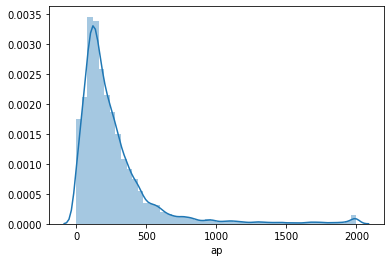

In [16]:
# distribution of assessment and plan lengths

temp = train_data.ap.str.split(' ').apply(len)
import seaborn as sns
sns.distplot(temp)


In [17]:
train_tokenizer = False
vocab_size = 10000
max_note_length = 512

In [18]:
# set up datasets for training
# this method requires a 'tokenizer' to turn unique words into unique numbers
if train_tokenizer:
    tokenizer = Tokenizer(num_words = vocab_size)
    tokenizer.fit_on_texts([str(x) for x in train_data['text']])
    with open('/homes10/klkehl/prissmm_notes_v2/notes_tokenizer_ap_find.pickle', 'wb') as handle:
         pickle.dump(tokenizer, handle, protocol=3)


In [19]:
# load tokenizer if already trained
with open('/homes10/klkehl/prissmm_notes_v2/notes_tokenizer_ap_find.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    

In [20]:
# ML imports
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, concatenate, Average
from tensorflow.keras.layers import Embedding
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, LSTM, TimeDistributed, GRU, Bidirectional, Layer
from tensorflow.keras import backend as K
#from keras_self_attention import SeqSelfAttention

In [21]:
# set up deep learning model


def get_simple_model(target):
    vocab_size = 10000
    embedding_dims = 256
    filters = 250
    if target == 'response':
        kernel_size = 5
    else:
        kernel_size = 3
    lstm_dims = 128
    epochs = 2
    hidden_dims = 128
    max_note_length=512
    batch_size = 32


    # make model
    text_input = Input(shape=(max_note_length,), dtype='float32')



    text_embed = Embedding(vocab_size, embedding_dims, input_length=max_note_length, mask_zero=False)(text_input)
    #text_embed = Dropout(0.5)(text_embed)

    
    cnn1 = Conv1D(filters=500, kernel_size=kernel_size, strides=1, padding='valid')(text_embed)
    x = GlobalMaxPooling1D()(cnn1)


    hidden = Dense(hidden_dims)(x)
    hidden = Activation('relu')(hidden)
    
    if target == 'response':
        # deepen network for response
        hidden = Dense(hidden_dims)(x)
        hidden = Activation('relu')(hidden)

    output = Dense(1, activation='linear')(hidden)




    model = Model(inputs=text_input, outputs=output)


    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

# specific structure chosen because in initial experiments, response worked a bit better with kernel_size ==5 with deeper net
# progression did a bit better with kernel_size==3 with shallower net

In [26]:
dummy_model = get_simple_model('progression')
print(dummy_model.summary())

x_text_valid = sequence.pad_sequences(tokenizer.texts_to_sequences([str(x) for x in valid_data['ap']]), maxlen=max_note_length, padding='post')
prediction_set = []

pd.set_option('mode.chained_assignment', None)

# do crossvalidation model training for each outcome


for i in range(10):

    thissplit_data = train_data[~train_data.dfci_mrn.isin(splits[i])]
    prediction_split = train_data[train_data.dfci_mrn.isin(splits[i])]
    prediction_split['split'] = 'train_' + str(i)
    
    x_text_train = sequence.pad_sequences(tokenizer.texts_to_sequences([str(x) for x in thissplit_data['ap']]), maxlen=max_note_length, padding='post')
    text_predict = sequence.pad_sequences(tokenizer.texts_to_sequences([str(x) for x in prediction_split['ap']]), maxlen=max_note_length, padding='post')

    for j in ['any_cancer', 'progression', 'response']:
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                filepath=j+str(i)+'.h5',
                # Path where to save the model
                # The two parameters below mean that we will overwrite
                # the current checkpoint if and only if
                # the `val_loss` score has improved.
                save_best_only=True,
                save_weights_only=True,
                monitor='val_loss',
                verbose=0),
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                min_delta=1e-2,
                patience=2,
                verbose=0
            )
        ]

        this_model = get_simple_model(j)
        
# uncomment the below to actually train the models; this was left commented out to avoid re-training after test set evaluation
#         this_model.fit(x_text_train, thissplit_data[j].values,
#                  validation_data=(x_text_valid, valid_data[j].values),
#                  epochs=5,
#                  batch_size = 32, verbose = 0, use_multiprocessing=True, callbacks=callbacks)

        this_model.load_weights(j+str(i)+'.h5')
        prediction_split['cv_'+j+'_prediction'] = this_model.predict(text_predict)
        
    
    prediction_set.append(prediction_split)
    

Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, 512)]             0         
_________________________________________________________________
embedding_40 (Embedding)     (None, 512, 256)          2560000   
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 510, 500)          384500    
_________________________________________________________________
global_max_pooling1d_40 (Glo (None, 500)               0         
_________________________________________________________________
dense_90 (Dense)             (None, 128)               64128     
_________________________________________________________________
activation_50 (Activation)   (None, 128)               0         
_________________________________________________________________
dense_91 (Dense)             (None, 1)                 129

In [27]:
def get_ensemble_model(outcome):
    model_list = []
    predictions = []
    ensemble_input = Input(shape=(max_note_length,), dtype='float32')
    for i in range(10):
        thismod = get_simple_model(outcome)
        thismod.load_weights(outcome+str(i)+'.h5')
        model_list.append(thismod)
    
    for i in range(10):
        predictions.append(model_list[i](ensemble_input))
    
    output = Average()(predictions)
    #output = Activation('sigmoid')(output)
    model = Model(inputs = ensemble_input, outputs = output)
    model.save_weights('ensemble_'+outcome+'.h5')
    return model
    
    
    
    

In [28]:
dummy_ensemble = get_ensemble_model('progression')
dummy_ensemble.summary()

Model: "model_85"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_76 (InputLayer)           [(None, 512)]        0                                            
__________________________________________________________________________________________________
model_75 (Model)                (None, 1)            3008757     input_76[0][0]                   
__________________________________________________________________________________________________
model_76 (Model)                (None, 1)            3008757     input_76[0][0]                   
__________________________________________________________________________________________________
model_77 (Model)                (None, 1)            3008757     input_76[0][0]                   
___________________________________________________________________________________________

In [29]:
# apply ensemble model to validation set data to evaluate it
x_text_valid = sequence.pad_sequences(tokenizer.texts_to_sequences([str(x) for x in valid_data['ap']]), maxlen=max_note_length, padding='post')

prediction_split = valid_data
prediction_split['split'] = 'valid'

for j in ['any_cancer', 'progression', 'response']:
    this_model = get_ensemble_model(j)
    prediction_split['cv_'+j+'_prediction'] = this_model.predict(x_text_valid)

prediction_set.append(prediction_split)
    

In [30]:
# do test set here, same as above
x_text_test = sequence.pad_sequences(tokenizer.texts_to_sequences([str(x) for x in test_data['ap']]), maxlen=max_note_length, padding='post')

prediction_split = test_data
prediction_split['split'] = 'test'

for j in ['any_cancer', 'progression', 'response']:
    this_model = get_ensemble_model(j)
    prediction_split['cv_'+j+'_prediction'] = this_model.predict(x_text_test)

prediction_set.append(prediction_split)
    

In [ ]:
# output machine-annotated dataset for subsequent analysis
output = pd.concat(prediction_set, axis=0).reset_index(drop=True)
output.to_feather(datafolder+'processed_aps.feather')
output.head()

In [32]:
# distribution of manually curated outcomes among curated notes
# (and then, number of patients with curated notes)

print(output.shape[0])
print(output.any_cancer.value_counts())
print(output.response.value_counts())
print(output.progression.value_counts())
print(len(output.dfci_mrn.unique()))

7597
1    6081
0    1516
Name: any_cancer, dtype: int64
0    6728
1     869
Name: response, dtype: int64
0    6085
1    1512
Name: progression, dtype: int64
919


In [33]:
%matplotlib inline

AUC 0.8942047477439471
Average precision score: 0.73
Best F1 
0.6666666666666667


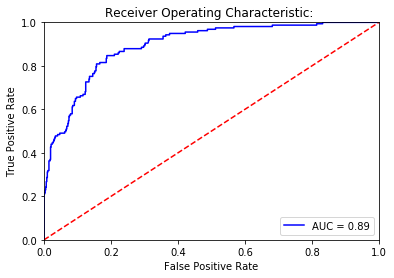

Outcome probability:
0.20231958762886598


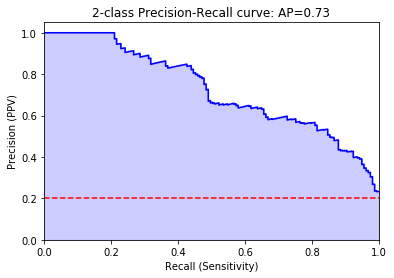

Threshold for best F1:
-1.2209483
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[522  97]
 [ 30 127]]


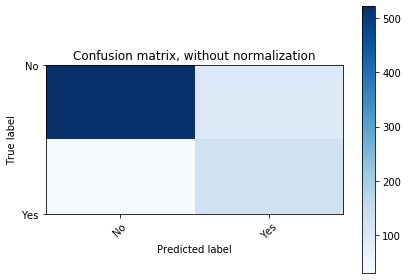

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.95      0.84      0.89       619
         Yes       0.57      0.81      0.67       157

    accuracy                           0.84       776
   macro avg       0.76      0.83      0.78       776
weighted avg       0.87      0.84      0.85       776

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[607  12]
 [ 90  67]]


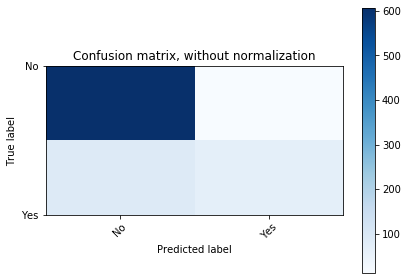

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.87      0.98      0.92       619
         Yes       0.85      0.43      0.57       157

    accuracy                           0.87       776
   macro avg       0.86      0.70      0.75       776
weighted avg       0.87      0.87      0.85       776



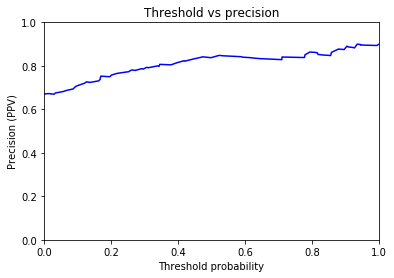

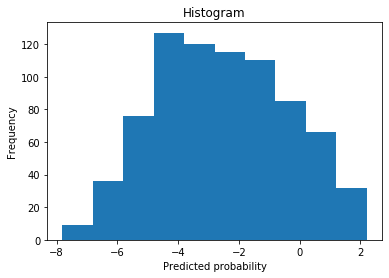

In [34]:
# validation set
output['progression_bestF1_thresh'] = eval_model(output[output['split']=='valid'].cv_progression_prediction, output[output['split']=='valid'].progression, graph=True)

AUC 0.896550048590865
Average precision score: 0.61
Best F1 
0.6100000000000001


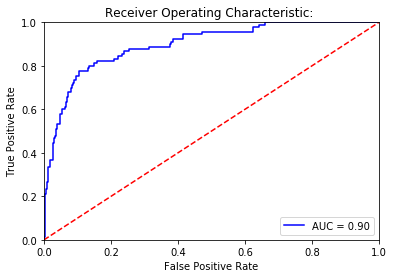

Outcome probability:
0.11597938144329897


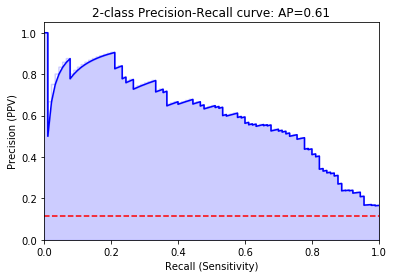

Threshold for best F1:
-0.9503568
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[637  49]
 [ 29  61]]


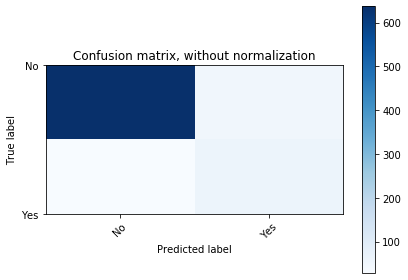

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.96      0.93      0.94       686
         Yes       0.55      0.68      0.61        90

    accuracy                           0.90       776
   macro avg       0.76      0.80      0.78       776
weighted avg       0.91      0.90      0.90       776

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[684   2]
 [ 71  19]]


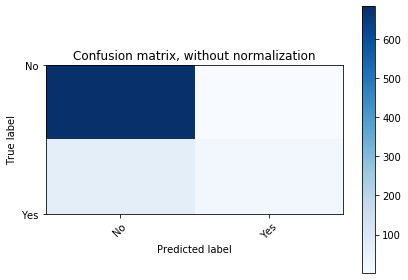

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.91      1.00      0.95       686
         Yes       0.90      0.21      0.34        90

    accuracy                           0.91       776
   macro avg       0.91      0.60      0.65       776
weighted avg       0.91      0.91      0.88       776



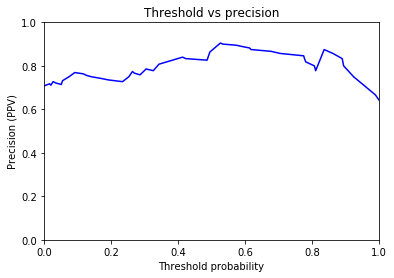

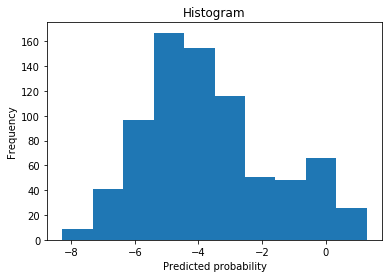

In [35]:
# validation set
output['response_bestF1_thresh'] = eval_model(output[output['split']=='valid'].cv_response_prediction, output[output['split']=='valid'].response, graph=True)

AUC 0.9371626180836707
Average precision score: 0.98
Best F1 
0.9485352335708631


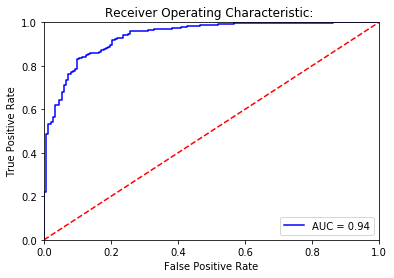

Outcome probability:
0.8041237113402062


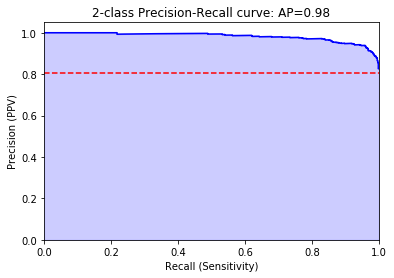

Threshold for best F1:
0.06843541
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[112  40]
 [ 25 599]]


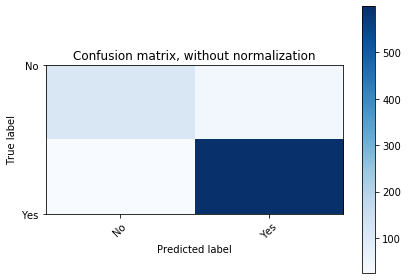

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.82      0.74      0.78       152
         Yes       0.94      0.96      0.95       624

    accuracy                           0.92       776
   macro avg       0.88      0.85      0.86       776
weighted avg       0.91      0.92      0.91       776

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[116  36]
 [ 42 582]]


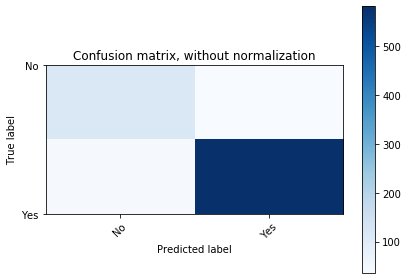

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.73      0.76      0.75       152
         Yes       0.94      0.93      0.94       624

    accuracy                           0.90       776
   macro avg       0.84      0.85      0.84       776
weighted avg       0.90      0.90      0.90       776



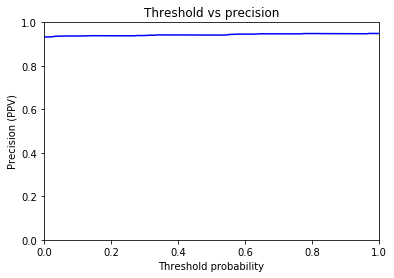

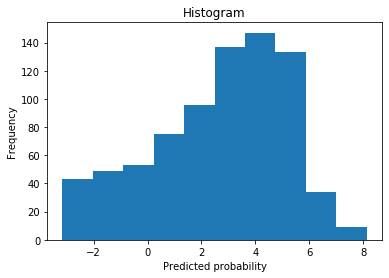

0.06843541

In [36]:
# validation set
eval_model(output[output['split']=='valid'].cv_any_cancer_prediction, output[output['split']=='valid'].any_cancer, graph=True)

AUC 0.8570273229482904
Average precision score: 0.65
Best F1 
0.6149253731343284


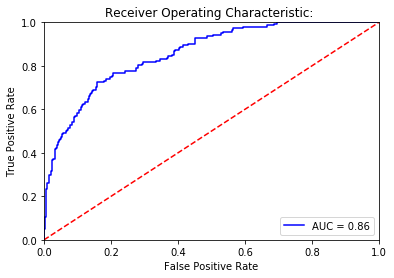

Outcome probability:
0.20056497175141244


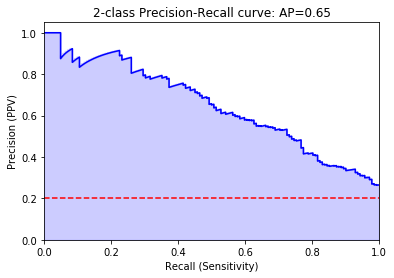

Threshold for best F1:
-1.3545334
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[476  90]
 [ 39 103]]


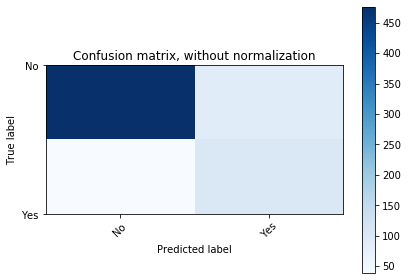

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.92      0.84      0.88       566
         Yes       0.53      0.73      0.61       142

    accuracy                           0.82       708
   macro avg       0.73      0.78      0.75       708
weighted avg       0.85      0.82      0.83       708

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[557   9]
 [100  42]]


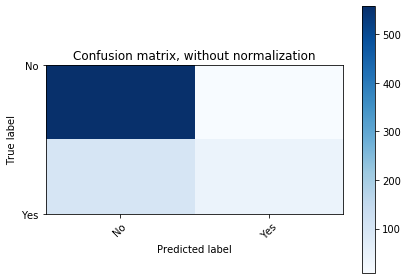

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.85      0.98      0.91       566
         Yes       0.82      0.30      0.44       142

    accuracy                           0.85       708
   macro avg       0.84      0.64      0.67       708
weighted avg       0.84      0.85      0.82       708



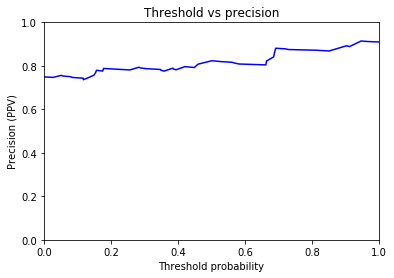

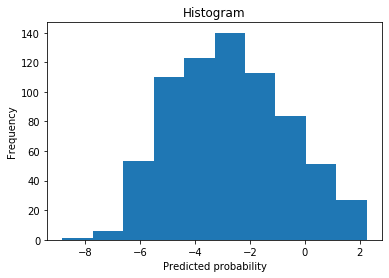

-1.3545334

In [37]:
# test set
eval_model(output[output['split']=='test'].cv_progression_prediction, output[output['split']=='test'].progression, graph=True)


AUC 0.901956626506024
Average precision score: 0.57
Best F1 
0.6351351351351351


/homes10/klkehl/prissmm_notes_v2/utils_092019_tf2.py:182: RuntimeWarning: invalid value encountered in true_divide
  F1 = 2*((precision*recall)/(precision+recall))


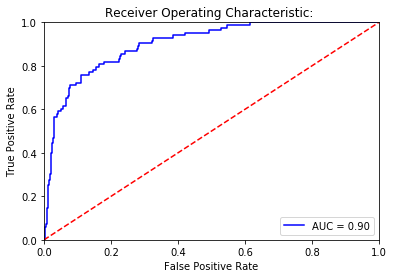

Outcome probability:
0.1172316384180791


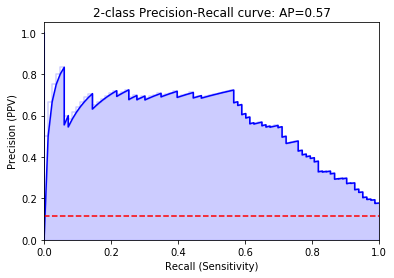

Threshold for best F1:
1.1350937
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[624   1]
 [ 83   0]]


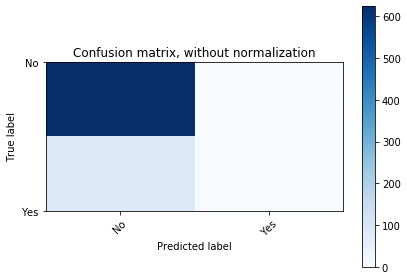

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.88      1.00      0.94       625
         Yes       0.00      0.00      0.00        83

    accuracy                           0.88       708
   macro avg       0.44      0.50      0.47       708
weighted avg       0.78      0.88      0.83       708

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[618   7]
 [ 69  14]]


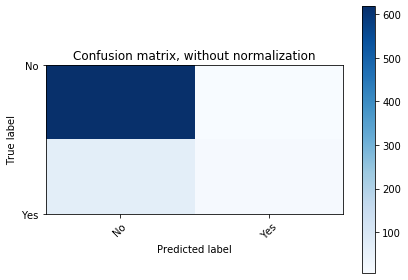

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.90      0.99      0.94       625
         Yes       0.67      0.17      0.27        83

    accuracy                           0.89       708
   macro avg       0.78      0.58      0.61       708
weighted avg       0.87      0.89      0.86       708



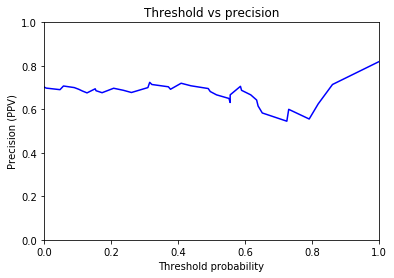

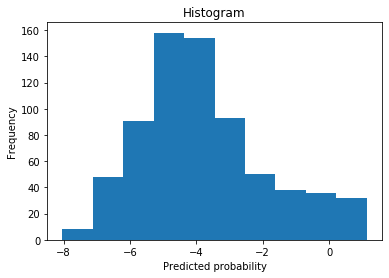

1.1350937

In [38]:
# test set
eval_model(output[output['split']=='test'].cv_response_prediction, output[output['split']=='test'].response, graph=True)


AUC 0.9352798648468412
Average precision score: 0.97
Best F1 
0.9345132743362832


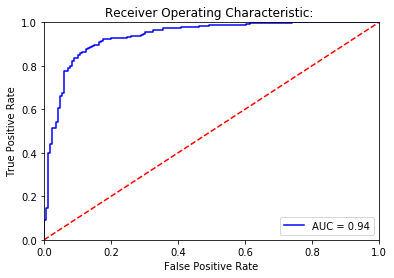

Outcome probability:
0.7655367231638418


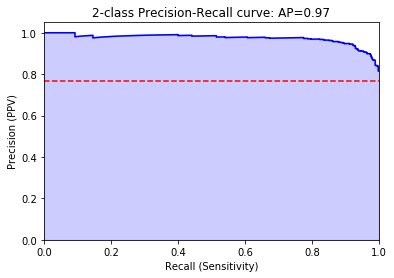

Threshold for best F1:
-0.22604711
Confusion matrix at best F1 thresh:
Confusion matrix, without normalization
[[106  60]
 [ 14 528]]


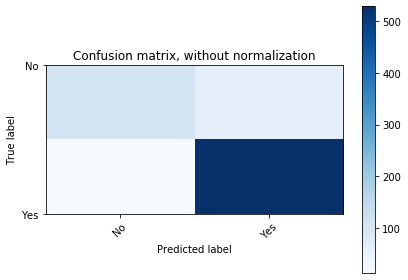

Metrics at best F1 thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.88      0.64      0.74       166
         Yes       0.90      0.97      0.93       542

    accuracy                           0.90       708
   macro avg       0.89      0.81      0.84       708
weighted avg       0.89      0.90      0.89       708

Confusion matrix at 0.5 thresh:
Confusion matrix, without normalization
[[120  46]
 [ 34 508]]


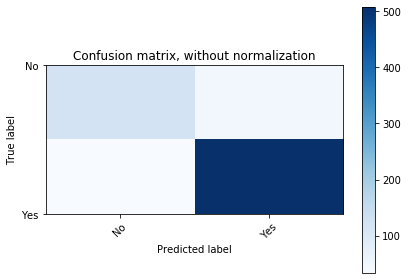

Metrics at 0.5 thresh thresh (specificity is recall for negative class):
              precision    recall  f1-score   support

          No       0.78      0.72      0.75       166
         Yes       0.92      0.94      0.93       542

    accuracy                           0.89       708
   macro avg       0.85      0.83      0.84       708
weighted avg       0.88      0.89      0.89       708



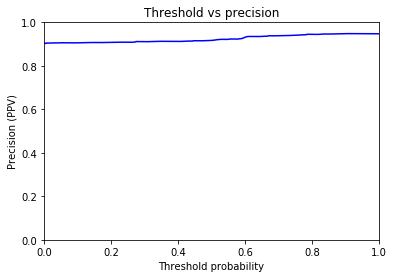

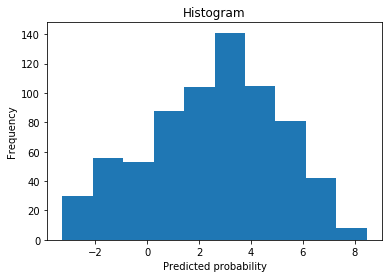

-0.22604711

In [39]:
# test set
eval_model(output[output['split']=='test'].cv_any_cancer_prediction, output[output['split']=='test'].any_cancer, graph=True)


In [88]:
# output machine-annotated dataset to R for Cox modeling

output.head()
to_r = output[['dfci_mrn','date','any_cancer','response','progression','cv_any_cancer_prediction','cv_progression_prediction','cv_response_prediction', 'progression_bestF1_thresh', 'response_bestF1_thresh']]

In [136]:
to_r.to_csv('to_r_temp.csv')
pall_rx.to_csv('to_pall_rx_temp.csv')
registration.to_csv('to_registration_temp.csv')

In [1]:
%load_ext rpy2.ipython
%reload_ext rpy2.ipython

In [12]:
%%R
library(dplyr)
library(readr)
to_r <- read_csv('to_r_temp.csv')

print("Proportion of notes with any cancer")
print(table(to_r$any_cancer)/nrow(to_r))

temp <- to_r %>% group_by(dfci_mrn) %>% mutate(patient_any_cancer=ifelse(any(any_cancer==1), 1, 0)) %>% filter(row_number()==1) %>% ungroup()
print("Proportion of patients with any cancer")
print(table(temp$any_cancer)/nrow(temp))

has_cancer <- to_r %>% filter(any_cancer==1)
print("Proportion of notes with cancer that have response")
print(table(has_cancer$response)/nrow(has_cancer))

print("Proportion of notes with cancer that have progression")
print(table(has_cancer$progression)/nrow(has_cancer))


R[write to console]: Parsed with column specification:
cols(
  X1 = col_double(),
  dfci_mrn = col_double(),
  date = col_date(format = ""),
  any_cancer = col_double(),
  response = col_double(),
  progression = col_double(),
  cv_any_cancer_prediction = col_double(),
  cv_progression_prediction = col_double(),
  cv_response_prediction = col_double(),
  progression_bestF1_thresh = col_double(),
  response_bestF1_thresh = col_double()
)



[1] "Proportion of notes with any cancer"

        0         1 
0.1995525 0.8004475 
[1] "Proportion of patients with any cancer"

        0         1 
0.1610446 0.8389554 
[1] "Proportion of notes with cancer that have response"

        0         1 
0.8570959 0.1429041 
[1] "Proportion of notes with cancer that have progression"

        0         1 
0.7513567 0.2486433 


In [2]:
%%R 

# Cox models were run both treating the response and progression outcomes as continuous (log odds per ML models), and using the best F1-cutoff
# best F1-cutoff results presented in the paper for ease of interpretation

library(dplyr)
library(survival)
library(readr)

registration <- read_csv('to_registration_temp.csv')
pall_rx <- read_csv('to_pall_rx_temp.csv')
to_r <- read_csv('to_r_temp.csv')

registration <- registration %>% mutate(hybrid_death_dt=as.Date(hybrid_death_dt, origin='1970-01-01')) %>% mutate(hybrid_death_dt = ifelse(is.na(hybrid_death_dt), as.Date('2018-01-01'), hybrid_death_dt)) %>% mutate(hybrid_death_dt = ifelse(hybrid_death_dt > as.Date('2017-12-31'), as.Date('2018-01-01'), hybrid_death_dt)) %>% mutate(event = ifelse(hybrid_death_dt==as.Date('2018-01-01'), 0,1)) %>% mutate(hybrid_death_dt=as.Date(hybrid_death_dt, origin='1970-01-01'))
pall_rx <- pall_rx %>% select(dfci_mrn, pall_start_dt) %>% mutate(pall_start_dt=as.Date(pall_start_dt, origin='1970-01-01'))



to_r <- to_r %>% mutate(date=as.Date(date, origin='1970-01-01')) %>%  inner_join(., pall_rx, by='dfci_mrn') %>% filter(date > pall_start_dt & date < as.Date('2018-01-01')) %>% rename(encounter_date=date) %>% mutate(predict_progression = ifelse(cv_progression_prediction > progression_bestF1_thresh, 1, 0)) %>% mutate(predict_response=ifelse(cv_response_prediction > response_bestF1_thresh,1,0))
print('Number of observations')
print(nrow(to_r))


analysis <- inner_join(to_r, registration, by='dfci_mrn') %>% mutate(encounter_censor_date = encounter_date + 180) 
print('Number of patients')
print(nrow(analysis %>% distinct(dfci_mrn)))

tdc_by_outcome <- analysis %>% arrange(dfci_mrn, encounter_date) %>% group_by(dfci_mrn) %>% mutate(first_encounter_date=first(encounter_date)) %>% group_by(dfci_mrn) %>% mutate(encounter_date = encounter_date - first(encounter_date)) %>% mutate(encounter_date=as.numeric(encounter_date)) %>% mutate(start=encounter_date) %>% mutate(end=lead(encounter_date)) %>% mutate(event_date = pmin(encounter_censor_date, hybrid_death_dt, na.rm=TRUE)) %>% mutate(elapsed_time=as.numeric(event_date - first_encounter_date)) %>%  mutate(end = ifelse(is.na(end), elapsed_time, end)) %>% mutate(died=ifelse(end==elapsed_time & end==(hybrid_death_dt-first_encounter_date),1,0)) %>% mutate(died=ifelse(is.na(died), 0, died))

head(tdc_by_outcome %>% select(dfci_mrn, start, end, died))
print(summary(coxph(Surv(start, end, died) ~ cv_progression_prediction + cv_response_prediction + cluster(dfci_mrn), data = tdc_by_outcome)))
print(summary(coxph(Surv(start, end, died) ~ predict_progression + predict_response + cluster(dfci_mrn), data = tdc_by_outcome)))

print(summary(coxph(Surv(start, end, died) ~ progression + response + cluster(dfci_mrn), data = tdc_by_outcome)))



R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Parsed with column specification:
cols(
  X1 = col_double(),
  dfci_mrn = col_double(),
  hybrid_death_ind = col_character(),
  hybrid_death_dt = col_date(format = ""),
  patient_id = col_double(),
  primary_cancer_diagnosis = col_character(),
  age_at_seq = col_character(),
  marital_status_nm = col_character(),
  idm_race_nm = col_character()
)

R[write to console]: Parsed with column specification:
cols(
  X1 = col_double(),
  dfci_mrn = col_double(),
  hybrid_death_ind = col_character(),
  hybrid_death_dt = col_date(format = ""),
  primary_cancer_diagnosis = col_character(),
  age_at_seq = col_character(),
  marital_status_nm = col_character(),
  idm_race_nm = col_character(),
  pall_start_dt = col_dat

[1] "Number of observations"
[1] 3004
[1] "Number of patients"
[1] 365
Call:
coxph(formula = Surv(start, end, died) ~ cv_progression_prediction + 
    cv_response_prediction, data = tdc_by_outcome, cluster = dfci_mrn)

  n= 2926, number of events= 327 
   (78 observations deleted due to missingness)

                              coef exp(coef) se(coef) robust se      z Pr(>|z|)
cv_progression_prediction  0.22321   1.25009  0.02654   0.02427  9.196   <2e-16
cv_response_prediction    -0.06003   0.94173  0.02833   0.02950 -2.035   0.0418
                             
cv_progression_prediction ***
cv_response_prediction    *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                          exp(coef) exp(-coef) lower .95 upper .95
cv_progression_prediction    1.2501     0.7999    1.1920    1.3110
cv_response_prediction       0.9417     1.0619    0.8888    0.9978

Concordance= 0.7  (se = 0.015 )
Likelihood ratio test= 98.95  on 2 df,   p=<2e-16
Wald test       

In [42]:
# lastly, train simple linear models using full text of document (without AP extraction step) to predict manual curations
# could be seen as a baseline demonstrating utility of the AP extraction step LSTM
# (not in paper, omitted for space--but the AP extraction step does yield final classification performance that is qualitatively better than these progression and response baselines)

train_output = output[output.split.str.contains('train')]
valid_output = output[output.split.str.contains('valid')]
# vectorizer for simple linear models


from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=500, ngram_range=(1,2), min_df=2, max_df=0.95)


train_text_matrix = vectorizer.fit_transform(train_output.ap).todense()
valid_text_matrix = vectorizer.transform(valid_output.ap).todense()

In [40]:
from sklearn.linear_model import SGDRegressor
#from sklearn.metrics import roc_auc_score, average_precision_score

lin_model = SGDRegressor(penalty='l1', 
                            alpha=0.001, random_state=42,
                            max_iter=50, tol=None)
lin_model.fit(train_text_matrix, train_output.cv_response_prediction)
features = pd.DataFrame()
features['coefs'] = lin_model.coef_.flatten()
features['names'] = vectorizer.get_feature_names()
features = features.sort_values(by='coefs', ascending=False)
high_prob_features = features.names[0:10]
low_prob_features = features.names[-10:]
print((features['coefs']==0).value_counts())
print(features.head(10), features.tail(10))
#lin_model.score(valid_text_matrix, valid_logit)

False    312
True     188
Name: coefs, dtype: int64
        coefs       names
377  5.265255    response
130  1.773914      cycles
120  1.512942   continued
210  1.498220    improved
118  1.343781    continue
129  1.287133       cycle
476  1.149843       weeks
341  1.149058  pemetrexed
486  1.020046        with
215  0.951502    in weeks         coefs       names
202 -0.859391        here
472 -0.977687          we
496 -1.142198       would
179 -1.162637         for
427 -1.204994        that
310 -1.214815          of
376 -1.555326   resection
371 -1.571881  recurrence
81  -1.616451      biopsy
45  -1.711110    adjuvant


In [41]:
from sklearn.linear_model import SGDRegressor
#from sklearn.metrics import roc_auc_score, average_precision_score

lin_model = SGDRegressor(penalty='l1', 
                            alpha=0.001, random_state=42,
                            max_iter=50, tol=None)
lin_model.fit(train_text_matrix, train_output.cv_progression_prediction)
features = pd.DataFrame()
features['coefs'] = lin_model.coef_.flatten()
features['names'] = vectorizer.get_feature_names()
features = features.sort_values(by='coefs', ascending=False)
high_prob_features = features.names[0:10]
low_prob_features = features.names[-10:]
print((features['coefs']==0).value_counts())
print(features.head(10), features.tail(10))
#lin_model.score(valid_text_matrix, valid_logit)

False    366
True     134
Name: coefs, dtype: int64
        coefs        names
360  3.672856  progression
326  2.489628      options
459  2.207435        trial
81   2.073673       biopsy
472  1.948309           we
85   1.666003        brain
429  1.582606          the
148  1.423030      disease
496  1.245481        would
145  1.211892    discussed         coefs       names
45  -1.436981    adjuvant
127 -1.579517     ct scan
371 -1.603568  recurrence
389 -1.613848        scan
152 -1.671338       doing
212 -1.698113   in months
118 -2.132193    continue
477 -2.230636        well
278 -2.242430      months
411 -2.335810      stable


In [42]:
from sklearn.linear_model import SGDRegressor
#from sklearn.metrics import roc_auc_score, average_precision_score

lin_model = SGDRegressor(penalty='l1', 
                            alpha=0.001, random_state=42,
                            max_iter=50, tol=None)
lin_model.fit(train_text_matrix, train_output.cv_any_cancer_prediction)
features = pd.DataFrame()
features['coefs'] = lin_model.coef_.flatten()
features['names'] = vectorizer.get_feature_names()
features = features.sort_values(by='coefs', ascending=False)
high_prob_features = features.names[0:10]
low_prob_features = features.names[-10:]
print((features['coefs']==0).value_counts())
print(features.head(10), features.tail(10))
#lin_model.score(valid_text_matrix, valid_logit)

False    361
True     139
Name: coefs, dtype: int64
        coefs        names
296  3.004540    nivolumab
85   2.874381        brain
360  2.716325  progression
268  2.597371   metastatic
458  2.529995    treatment
377  2.512841     response
227  2.388701           iv
413  2.262070     stage iv
448  2.173031           to
341  1.500682   pemetrexed         coefs        names
212 -2.302365    in months
176 -2.335785       follow
126 -2.438886           ct
166 -2.550193  evidence of
298 -2.641320  no evidence
165 -2.717480     evidence
376 -2.938939    resection
278 -3.713006       months
371 -4.645219   recurrence
45  -4.905690     adjuvant


In [43]:
# simple logistic regression baseline for progression
from sklearn.linear_model import SGDClassifier, LogisticRegression, SGDRegressor
from sklearn.metrics import roc_auc_score, average_precision_score

# logistic_model = SGDClassifier(loss='log', penalty='l2',
#                            alpha=1e-3, random_state=42,
#                            max_iter=5, tol=None)

logistic_model = LogisticRegression(penalty='l2', C=1)
logistic_model.fit(train_text_matrix, train_output.progression.values)
valid_predictions_logit = logistic_model.predict_proba(valid_text_matrix)[:,1]
roc_auc_score(valid_output.progression.values, valid_predictions_logit), average_precision_score(valid_output.progression.values, valid_predictions_logit)

/homes10/klkehl/anaconda3/envs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.8131154625809041, 0.5774349024108028)

In [44]:
train_text_matrix.shape

(6113, 500)

In [45]:
# simple logistic regression baseline for response
from sklearn.linear_model import SGDClassifier, LogisticRegression, SGDRegressor
from sklearn.metrics import roc_auc_score, average_precision_score

# logistic_model = SGDClassifier(loss='log', penalty='l2',
#                            alpha=1e-3, random_state=42,
#                            max_iter=5, tol=None)

logistic_model = LogisticRegression(penalty='l2', C=1)
logistic_model.fit(train_text_matrix, train_output.response.values)
valid_predictions_logit = logistic_model.predict_proba(valid_text_matrix)[:,1]
roc_auc_score(valid_output.response.values, valid_predictions_logit), average_precision_score(valid_output.response.values, valid_predictions_logit)

/homes10/klkehl/anaconda3/envs/tf2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(0.8274133462908974, 0.41351325088676566)